In [1]:
import json
from collections import Counter, defaultdict
import scipy.sparse as sp
import numpy as np
import pandas as pd
import nltk
import re
import os
import copy
import codecs
from sklearn import feature_extraction
import string
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stopwords = set(nltk.corpus.stopwords.words('english'))
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [3]:
def load_df_from_json():
    cwd = os.getcwd()
    frames = []
    path = 'lyrics_json_09-18/'
    for file in os.listdir(path):
        date = file.split('.')[0].split('_')[-1]
        with open(path + file, 'r') as f:
            df = pd.DataFrame(json.load(f)).dropna()
            df['time'] = pd.Timestamp(date)
            frames.append(df)
    raw_data = pd.concat(frames)
    return raw_data.drop_duplicates(['title','artist']).reset_index() 

In [4]:
def preprocess(lyric):
    lyric = lyric.lower()
    lyric = re.sub(r'\[.*?\]', '', lyric)  # remove [*] pattern
    lyric = lyric.replace("'s", '')
    lyric = lyric.replace("'ve", '')
    lyric = lyric.replace("'", '')  # ' must be ignored
    lyric = lyric.replace("-", ' ')

    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    lyric = lyric.translate(translator)
#     tokens = nltk.word_tokenize(lyric)

    return lyric #[w for w in tokens if w not in stopwords]

def words2sentence(words):
    return ' '.join(words)

In [5]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
raw_data = load_df_from_json()
billboard = copy.deepcopy(raw_data)
print(billboard)

      index                                           artist  \
0         1                           T.I. Featuring Rihanna   
1         2                Lady Gaga Featuring Colby O'Donis   
2         3                                       Kanye West   
3         4                                   Britney Spears   
4         5                                       Katy Perry   
5         6                                     Taylor Swift   
6         7                                       Kanye West   
7         8                                             T.I.   
8        10                                   Britney Spears   
9        11                                       Jason Mraz   
10       12                 Kevin Rudolf Featuring Lil Wayne   
11       13                                            Ne-Yo   
12       15                                             P!nk   
13       16                                       Nickelback   
14       17                             

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in billboard['lyrics']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

print(billboard.head(20))

    index                                           artist  \
0       1                           T.I. Featuring Rihanna   
1       2                Lady Gaga Featuring Colby O'Donis   
2       3                                       Kanye West   
3       4                                   Britney Spears   
4       5                                       Katy Perry   
5       6                                     Taylor Swift   
6       7                                       Kanye West   
7       8                                             T.I.   
8      10                                   Britney Spears   
9      11                                       Jason Mraz   
10     12                 Kevin Rudolf Featuring Lil Wayne   
11     13                                            Ne-Yo   
12     15                                             P!nk   
13     16                                       Nickelback   
14     17                                          Rihanna   
15     1

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 1534550 items in vocab_frame
        words
sampl  sample
x4         x4
over     over
intro   intro
miya     miya


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(billboard['lyrics']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)

Wall time: 39 s
(3342, 65)
["'m", 'ai', "ai n't", 'babi', 'bitch', 'boy', 'bridg', 'ca', "ca n't", 'caus', 'chorus', 'come', 'day', 'did', 'everi', 'eye', 'feel', 'fuck', 'girl', 'gon', 'gon na', 'good', 'got', 'got ta', 'heart', 'hold', 'hook', 'intro', 'just', 'know', 'let', 'life', 'like', 'littl', 'll', 'look', 'love', 'make', 'man', 'na', 'need', 'nigga', 'night', 'oh', 'onli', 'outro', 'pre-chorus', 'right', 'said', 'say', 'shit', 'ta', 'tell', 'thing', 'think', 'time', 'tri', 'turn', 've', 'wan', 'wan na', 'want', 'way', 'whi', 'yeah']


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(2,2),max_features=25,stop_words='english',analyzer ='word',strip_accents='ascii')
bigrams=word_vectorizer.fit(billboard['lyrics']).vocabulary_
bigrams

{'ah ah': 0,
 'baby don': 1,
 'da da': 2,
 'don know': 3,
 'don need': 4,
 'don wanna': 5,
 'don want': 6,
 'feel like': 7,
 'hey hey': 8,
 'just like': 9,
 'just wanna': 10,
 'know know': 11,
 'la la': 12,
 'love love': 13,
 'low low': 14,
 'na na': 15,
 'new directions': 16,
 'oh oh': 17,
 'oh yeah': 18,
 'ooh ooh': 19,
 'post chorus': 20,
 'pre chorus': 21,
 've got': 22,
 'want want': 23,
 'yeah yeah': 24}

In [11]:
tri = CountVectorizer(ngram_range=(3,3),max_features=25,stop_words='english',analyzer ='word',strip_accents='ascii')
trigrams=tri.fit(billboard['lyrics']).vocabulary_
trigrams

{'ah ah ah': 0,
 'bum bum bum': 1,
 'da da da': 2,
 'don don don': 3,
 'don know don': 4,
 'eh eh eh': 5,
 'hey hey hey': 6,
 'know don know': 7,
 'know know know': 8,
 'la la la': 9,
 'love love love': 10,
 'low low low': 11,
 'ma ma ma': 12,
 'na na na': 13,
 'oh oh oh': 14,
 'ooh ooh ooh': 15,
 'shake shake shake': 16,
 'shaky shaky shaky': 17,
 'uh uh uh': 18,
 'verse lil wayne': 19,
 'want want want': 20,
 'woah oh oh': 21,
 'woah woah woah': 22,
 'work work work': 23,
 'yeah yeah yeah': 24}

In [12]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
billboard['clusters'] = clusters
billboard['clusters'].value_counts() #number of films per cluster (clusters from 0 to 4)

Wall time: 13.9 s


1    1288
4     948
2     444
3     415
0     247
Name: clusters, dtype: int64

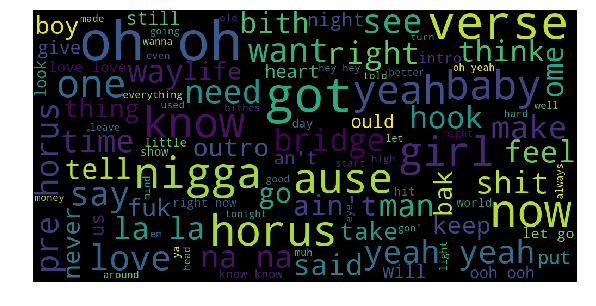

In [13]:
allwords = ' '.join(billboard['lyrics']).lower().replace('c', '')
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=100,
                            width=1000,
                            height=500,
                            max_words=100,
                            relative_scaling=.5).generate(allwords)

plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(cloud)

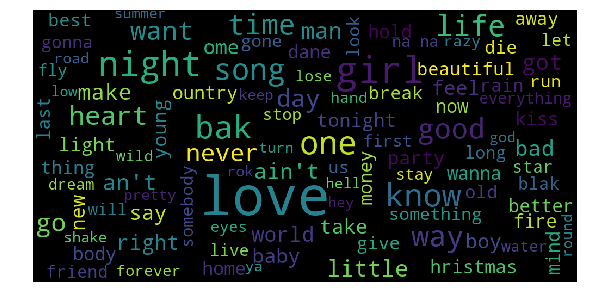

In [14]:
allwords = ' '.join(billboard['title']).lower().replace('c', '')
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=100,
                            width=1000,
                            height=500,
                            max_words=100,
                            relative_scaling=.5).generate(allwords)
plt.figure(figsize=(15,5))
plt.axis('off')

plt.imshow(cloud);

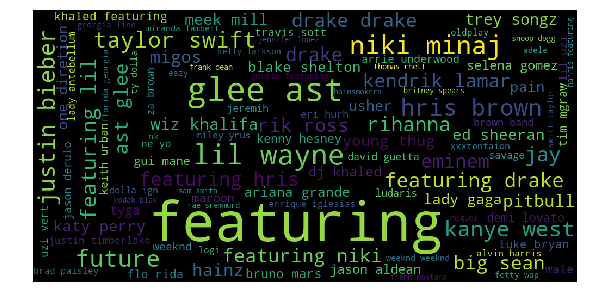

In [15]:
allwords = ' '.join(billboard['artist']).lower().replace('c', '')
cloud = wordcloud.WordCloud(background_color='black',
                            max_font_size=100,
                            width=1000,
                            height=500,
                            max_words=100,
                            relative_scaling=.5).generate(allwords)
plt.figure(figsize=(15,5))
plt.axis('off')

plt.imshow(cloud);

In [16]:
frame = billboard.set_index(billboard['clusters'])
# del test['index']
frame

,index,artist,lyrics,title,time,clusters
clusters,,,,,,
1,1,T.I. Featuring Rihanna,"[Sample x4 (over intro)] Miya hee, miya ho, ...",Live Your Life,2009-01-03,1
2,2,Lady Gaga Featuring Colby O'Donis,"[Intro] RedOne Konvict Gaga (oh-oh, eh) [Ve...",Just Dance,2009-01-03,2
1,3,Kanye West,"[Chorus] In the night, I hear 'em talk The c...",Heartless,2009-01-03,1
1,4,Britney Spears,"[Verse 1] Superstar, where you from? How's i...",Womanizer,2009-01-03,1
1,5,Katy Perry,[Verse 1] You change your mind like a girl c...,Hot N Cold,2009-01-03,1
1,6,Taylor Swift,[Verse 1] We were both young when I first sa...,Love Story,2009-01-03,1
1,7,Kanye West,[Produced by Kanye West and Jeff Bhasker] [...,Love Lockdown,2009-01-03,1
4,8,T.I.,"[Intro] Ayy, Jim, you know the ol' sugar dad...",Whatever You Like,2009-01-03,4
4,10,Britney Spears,[Verse 1] There's only two types of people i...,Circus,2009-01-03,4


In [20]:


print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
   
#     for title in frame.ix[i]['title'].values.tolist():
#         print(' %s,' % title, end='')

    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'oh', b'yeah', b"'m", b'chorus', b'knows', b'like', b'love', b'baby', b'got', b'just', b'let', b'cause', b'feel', b'heart', b'time', b'come', b"'ll", b'want', b'say', b'make',



Cluster 1 words: b'love', b'chorus', b"'ll", b'knows', b'let', b'baby', b'just', b'like', b"'ve", b'come', b'time', b"'m", b'want', b'say', b'heart', b'night', b'feel', b'way', b'ca', b'ca',



Cluster 2 words: b'na', b'wan', b'wan', b'gon', b'gon', b"'m", b'like', b'just', b'baby', b'love', b'chorus', b'yeah', b'knows', b'got', b'let', b'make', b"'ll", b'girl', b'oh', b'night',



Cluster 3 words: b'nigga', b'bitch', b"'m", b'fuck', b'got', b'like', b'shit', b'ai', b'ai', b'yeah', b'knows', b'hook', b'just', b'man', b'make', b'look', b'gon', b'want', b'cause', b'say',



Cluster 4 words: b"'m", b'like', b'got', b'yeah', b'girl', b'knows', b'just', b'ai', b'ai', b'baby', b'cause', b'hook', b'chorus', b'want', b'feel', b'make', b'let', b'say', b'ta', b'got',





